# Q5's Teamwork

- Aleksandar Mona Macko Puhek
- Chuying He
- Ioannis Lavdas
- Lorena Mendez
- Pantelis Fragkos

# Introduction

Explain...

# Idea

Explain what your idea is.

# Solution

## "Naive" GHZ State Generation

In [5]:
from qiskit import QuantumCircuit, execute, Aer

def generate_naive_ghz_state(qubit_amount):
    """Prepare a GHZ state on n qubits."""
    # Initialize a quantum circuit with n qubits
    qc = QuantumCircuit(qubit_amount)

    # Apply a Hadamard gate to the first qubit
    qc.h(0)

    # Apply a CNOT gate between the first qubit and each of the other qubits
    for i in range(1, qubit_amount):
        qc.cx(0, i)

    qc.measure_all()

    return qc

## Generalized GHZ State Generation

In [6]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer

def generate_generalized_ghz_state(qubit_amount):
    total_qubit_amount = 2*qubit_amount-1
    
    qr = QuantumRegister(total_qubit_amount)
    cr = ClassicalRegister(total_qubit_amount)
    qc = QuantumCircuit(qr, cr)
    
    even_qubit_list = list(range(0,2*qubit_amount,2))
    odd_qubit_list = list(range(1,2*qubit_amount-1,2))
        
    qc.h(even_qubit_list)
    qc.cx(even_qubit_list[:-1], odd_qubit_list)
    qc.cx(even_qubit_list[1:], odd_qubit_list)
    
    qc.measure(qr[1::2], cr[1::2])
    
    # Measure and perform conditional operations
    n = total_qubit_amount
    
    for i in range(1, n, 2):
        with qc.if_test((cr[i], 1)):
            qc.x(list(range(i+1, n, 2)))
    
    qc.barrier()
    
    qc.measure(qr[::2], cr[::2])
    
    return qc

# Results

## Plotting

In [7]:
from qiskit import IBMQ, transpile
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.tools.visualization import plot_histogram

from qiskit.providers.fake_provider import FakeSherbrooke

def plot_noise(qc):
    # Fake Provider Backends
    device_backend = FakeSherbrooke()

    sim_sherbrooke = AerSimulator.from_backend(device_backend)

    # Transpile the circuit for the noisy basis gates
    t_qc = transpile(qc, sim_sherbrooke)

    # Execute noisy simulation and get counts
    result_noise = sim_sherbrooke.run(t_qc).result()
    counts_noise = result_noise.get_counts(0)
    return counts_noise    

In [8]:
def cluster_counts(counts_noise, qubit_amount):
    new_counts = {}
    for el in counts_noise: 
        even_list = [el[i] for i in range(0, qubit_amount*2-1, 2)]
        try:
            new_counts["".join(even_list)] = new_counts["".join(even_list)] + counts_noise[el]
        except:
            new_counts["".join(even_list)] = counts_noise[el]
    return new_counts

In [9]:
# INPUT VARIABLE
qubit_amount=5

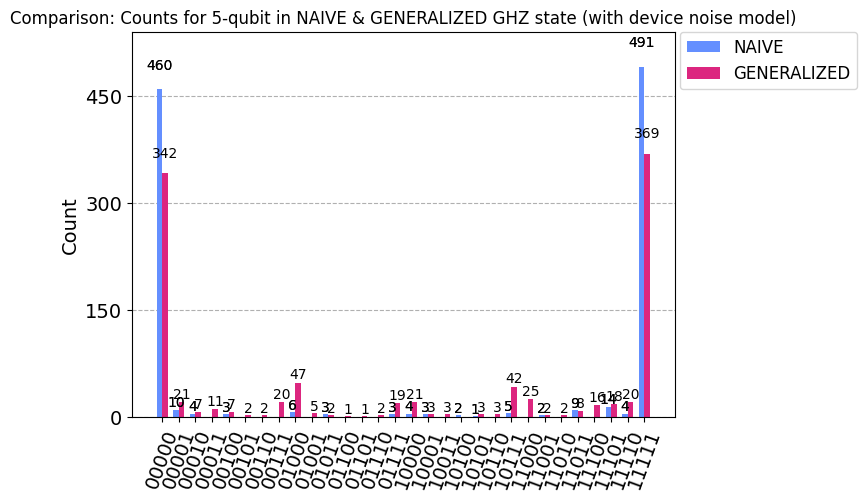

In [10]:
# PLOTTING NAIVE & GENERALIZED GHZ STATE
## NAIVE
naive_qc = generate_naive_ghz_state(qubit_amount)
naive_counts_noise = plot_noise(naive_qc)

## GENERALIZED
generalized_qc = generate_generalized_ghz_state(qubit_amount)
generalized_counts_noise=plot_noise(generalized_qc)
clusterd_generalized_counts_noise = cluster_counts(generalized_counts_noise, qubit_amount)

## PLOTTING
legend = ["NAIVE", "GENERALIZED"]
plot_histogram([naive_counts_noise,clusterd_generalized_counts_noise],
               legend=legend,
               title=f"Comparison: Counts for {qubit_amount}-qubit in NAIVE & GENERALIZED GHZ state (with device noise model)")

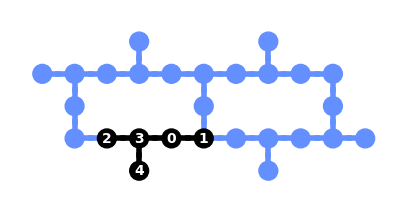

In [19]:
from qiskit.visualization import plot_circuit_layout
from qiskit.providers.fake_provider import FakeTorontoV2

# Fake Provider Backends
device_backend = FakeTorontoV2()

sim_sherbrooke = AerSimulator.from_backend(device_backend)

# Transpile the circuit for the noisy basis gates
t_qc = transpile(naive_qc, sim_sherbrooke)

plot_circuit_layout(t_qc, device_backend)


In [20]:
from qiskit.providers.models import BackendConfiguration
# BackendConfiguration(device_backend, coupling_map)
print(device_backend.coupling_map)

[[16, 14], [14, 16], [9, 8], [8, 9], [5, 8], [8, 5], [5, 3], [3, 5], [26, 25], [25, 26], [18, 17], [17, 18], [18, 15], [15, 18], [12, 15], [15, 12], [2, 3], [3, 2], [13, 12], [12, 13], [25, 24], [24, 25], [12, 10], [10, 12], [19, 22], [22, 19], [7, 10], [10, 7], [25, 22], [22, 25], [6, 7], [7, 6], [11, 8], [8, 11], [21, 18], [18, 21], [7, 4], [4, 7], [19, 16], [16, 19], [1, 4], [4, 1], [14, 11], [11, 14], [24, 23], [23, 24], [2, 1], [1, 2], [20, 19], [19, 20], [23, 21], [21, 23], [0, 1], [1, 0], [13, 14], [14, 13]]
